In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from datetime import datetime

import os
import sys
sys.path.append("../src/utils")
from eda_tools import *
from evaluate_model import *

# Python
import itertools
from sklearn.model_selection import ParameterGrid


# Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

from azureml.core import Datastore, Dataset, Run
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

C:\Users\XA155XB\Anaconda3\envs\walmart2\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\XA155XB\Anaconda3\envs\walmart2\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\XA155XB\Anaconda3\envs\walmart2\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)
Importing plotly failed. Interactive plots will not work.
Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (numpy 1.21.5 (c:\users\xa155xb\anaconda3\envs\walmart2\lib\site-packages), Requirement.parse('numpy<=1.19.3; sys_platform == "win32"'), {'azureml-dataset-runtime'}).


## Reading in Dataset

### Weekly Sales

In [2]:
sales = pd.read_csv("../walmart_sales/train_payload2_azureml v3.csv")
sales.head()

,Region,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
0,1,5/2/2010,1643690.90,42.31,2.572,211.096358,8.106,151315
1,1,12/2/2010,1641957.44,38.51,2.548,211.242170,8.106,151315
2,1,19/2/10,1611968.17,39.93,2.514,211.289143,8.106,151315
3,1,26/2/10,1409727.59,46.63,2.561,211.319643,8.106,151315
4,1,5/3/2010,1554806.68,46.50,2.625,211.350143,8.106,151315


In [3]:
# Converting dates
sales["Date"] = pd.to_datetime(sales["Date"])

# # Dropping DMZ.1 column
# sales = sales.drop(["DMZ.1"], axis=1)

sales.head()

,Region,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
0,1,2010-05-02,1643690.90,42.31,2.572,211.096358,8.106,151315
1,1,2010-12-02,1641957.44,38.51,2.548,211.242170,8.106,151315
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,151315
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,151315
4,1,2010-05-03,1554806.68,46.50,2.625,211.350143,8.106,151315


In [4]:
missing_data(sales)

,Region,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
Total,1380,1380,1380,1380,1380,1380,1380,1380
Missing,0,0,0,0,0,0,0,0
Percent Missing(%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,datetime64[ns],float64,float64,float64,float64,float64,int64


## Train Test Split

In [259]:
# train_df, test_df = train_test_split_timeseries(region, split=0.2, group="Region")
train_df = pd.read_csv("../walmart_sales/train_payload2_azureml v3.4.csv")
test_df = pd.read_csv("../walmart_sales/test_payload2_azureml v3.4.csv")

try:
    
    train_df["Date"] = pd.to_datetime(train_df["Date"], format="%d/%m/%y")
    test_df["Date"] = pd.to_datetime(test_df["Date"], format="%d/%m/%y")
    print("Re-formatted dates")
except:
    print("Dates are in the right order")

# train_df = train_df.drop(["Type"], axis=1)
# test_df = test_df.drop(["Type"], axis=1)

Dates are in the right order


In [258]:
# train_df.to_csv("../walmart_sales/train_payload2_azureml v3.4.csv", index=False)
# test_df.to_csv("../walmart_sales/test_payload2_azureml v3.4.csv", index=False)

In [260]:
train_df

,Region,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,151315
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,151315
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,151315
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,151315
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,151315
...,...,...,...,...,...,...,...,...
1375,12,2012-03-16,1088498.52,64.44,4.273,130.826193,12.187,112238
1376,12,2012-03-23,1045419.87,56.26,4.038,130.896645,12.187,112238
1377,12,2012-03-30,1025382.22,64.36,4.294,130.967097,12.187,112238
1378,12,2012-04-06,1128765.71,64.05,4.121,131.037548,11.627,112238


In [261]:
missing_data(train_df)

,Region,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
Total,1380,1380,1380,1380,1380,1380,1380,1380
Missing,0,0,0,0,0,0,0,0
Percent Missing(%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,object,float64,float64,float64,float64,float64,int64


In [262]:
missing_data(test_df)

,Region,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
Total,336,336,336,336,336,336,336,336
Missing,0,0,0,0,0,0,0,0
Percent Missing(%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,object,float64,float64,float64,float64,float64,int64


## One-Hot Encode Categorical Variables

In [263]:
target = "Weekly_Sales"
time = "Date"
group = ["Region"]

In [264]:
# Time & Target column
train = train_df.rename(columns = {time: "ds", target:"y"})
test = test_df.rename(columns = {time: "ds", target:"y"})

train.set_index(group, inplace=True)
test.set_index(group, inplace=True)

In [265]:
# Getting the categorical variables
temp_train = train.drop(["ds", "y" ], axis=1)

cat_variables = temp_train.select_dtypes(include="O").keys()

In [266]:
# One-hot encode
for cat_variable in cat_variables:
    # Take only top 10 lables
    top_10 = list(temp_train[cat_variable].value_counts().sort_values(ascending=False).head(10).index)

    # Drop one to avoid perfect multicollinearity
    top_10 = top_10[1:]

    # Encoding the labels
    ### Train dataset ###
    for label in top_10:
        train[cat_variable + "_" + label] = np.where(train[cat_variable]==label, 1, 0)

    # Remove original column
    train.drop([cat_variable], axis=1, inplace=True)

    ### Test dataset ###
    for label in top_10:
        test[cat_variable + "_" + label] = np.where(test[cat_variable]==label, 1, 0)

    # Remove original column
    test.drop([cat_variable], axis=1, inplace=True)



## Prophet training

In [267]:
# # Time & Target column
# train = train_df.rename(columns = {time: "ds", target:"y"})
# test = test_df.rename(columns = {time: "ds", target:"y"})

# Additional Regressors
ADDITIONAL_REGRESSORS = train.drop(["ds", "y"], axis=1).columns

In [268]:
ADDITIONAL_REGRESSORS

Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size'], dtype='object')

In [269]:
GROUPS = train.index.unique()
# GROUPS = [ (x, ) for x in train.index.unique()]

In [270]:
GROUPS

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='Region')

In [195]:
model_collection = {}

for region in GROUPS:
    model = Prophet(
        growth="linear",
        changepoint_range=0.69,
        holidays_prior_scale=0.25, changepoint_prior_scale=0.05, 
        seasonality_mode = "additive", seasonality_prior_scale= 30,
        yearly_seasonality="auto",
        weekly_seasonality="auto",
        daily_seasonality="auto",
    )
    model.add_country_holidays(country_name="US")

    for col in ADDITIONAL_REGRESSORS:
        # print(col)
        model.add_regressor(name=col, standardize='auto', mode='additive')
    model_collection[region] = model

In [271]:
# train_df[train_df["Region"] == 1]
train.loc[1,:]

,ds,y,Temperature,Fuel_Price,CPI,Unemployment,Size
Region,,,,,,,
1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,151315
1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,151315
1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,151315
1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,151315
1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,151315
...,...,...,...,...,...,...,...
1,2012-03-16,1677472.78,64.74,3.734,221.211813,7.348,151315
1,2012-03-23,1511068.07,65.93,3.787,221.286413,7.348,151315
1,2012-03-30,1649604.63,67.61,3.845,221.361012,7.348,151315


In [27]:
model_collection[4].fit(temp)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
# __here__ = os.path.dirname(__file__)
# output_dir = os.path.join(__here__, 'outputs')

output_dir = os.path.join(os.getcwd(), "models")
os.makedirs(output_dir, exist_ok=True)
model_path = os.path.join(output_dir, "model.pkl")

In [44]:
joblib.dump(model_collection, model_path)

['c:\\Users\\XA155XB\\OneDrive - EY\\Documents\\GitHub\\WalmartSales\\notebooks\\models\\model.pkl']

In [46]:
model_collection = joblib.load(model_path)

In [103]:
# Training
for region, model in list(model_collection.items())[:3]:
    print(region)
    curr_train = train.loc[region, :]

    model.fit(curr_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3
4


KeyboardInterrupt: 

## AzureML SDK

In [1]:
from azureml.core import Workspace

# ws = Workspace.from_config()

ws = Workspace.get(name="Walmart-Sales", 
    subscription_id =  "ef0073f1-56e3-462f-80b3-3beb320211e4",
    resource_group = "Walmart-1"
)

Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (numpy 1.21.5 (c:\users\xa155xb\anaconda3\envs\walmart2\lib\site-packages), Requirement.parse('numpy<=1.19.3; sys_platform == "win32"'), {'azureml-dataset-runtime'}).


In [23]:
from azureml.core import Experiment

# create an experiment variable
experiment = Experiment(workspace = ws, name = "walmart-sales-1")

In [24]:
experiment.id

'd8196ed6-ecff-42c1-a740-2356ea8a73c1'

In [13]:
run_ids = []
for run in experiment.get_runs():
    run_ids.append(run)

In [14]:
run_id = run_ids[0]

In [15]:
run_id.get_file_names()

['models/model.pkl']

In [21]:
# run_id.download_file(name="models/model.pkl", output_file_path = "./models/model.pkl")

In [27]:
run_id.experiment.id

'51cfffda-52b7-4b3b-9248-b56b321175dc'

In [286]:


# start the experiment
run = experiment.start_logging()


In [287]:
# Getting the regressors to add to prophet
ADDITIONAL_REGRESSORS = train.drop(["ds", "y"], axis=1).columns

# Getting the unique groups
GROUPS = train.index.unique()

In [288]:
# Creating Model
model_collection = {}

for region in GROUPS:
    model = Prophet(
        growth="linear",
        changepoint_range=0.69,
        holidays_prior_scale=0.25, changepoint_prior_scale=0.05, 
        seasonality_mode = "additive", seasonality_prior_scale= 30,
        yearly_seasonality="auto",
        weekly_seasonality="auto",
        daily_seasonality="auto",
    )
    model.add_country_holidays(country_name="US")

    for col in ADDITIONAL_REGRESSORS:
        # print(col)
        model.add_regressor(name=col, standardize='auto', mode='additive')
    model_collection[region] = model

In [289]:
# Training
for region, model in list(model_collection.items())[:3]:
    print(region)
    curr_train = train.loc[region, :]

    model.fit(curr_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3


In [290]:
# Defining path to save the model

# __here__ = os.path.dirname(__file__)
# output_dir = os.path.join(__here__, 'outputs')

output_dir = os.path.join(os.getcwd(), "models")
os.makedirs(output_dir, exist_ok=True)
model_path = os.path.join(output_dir, "model.pkl")

# Saving the model
joblib.dump(model_collection, model_path)

['c:\\Users\\XA155XB\\OneDrive - EY\\Documents\\GitHub\\WalmartSales\\notebooks\\models\\model.pkl']

In [291]:
path = run.upload_file("models/model.pkl", model_path)

In [292]:
master_model = run.register_model(
    model_name = "Prophet",
    model_path = "models/model.pkl"
)

run.log("Model_ID", master_model.id)

In [293]:
master_model.id

'Prophet:4'

In [294]:
# Log the row count
run.log('observations', len(train.loc[1, ]))

# end the experiment
run.complete()

In [285]:
ws.get_default_datastore()

INFO:azureml.data.datastore_client:<azureml.core.authentication.InteractiveLoginAuthentication object at 0x00000203A989E748>


{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-58018f5f-a704-46b4-b4da-c5cee3b94c2d",
  "account_name": "walmartsales2005913347",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

In [ ]:
ds1 = ws.datasets["train_payload2_azureml v3"]
ds1.name

In [78]:
dataset = Dataset.get_by_name(ws, name = ds1.name)
df = dataset.to_pandas_dataframe()

## Forecasting

In [106]:
if "y" in test.columns:
    test = test.drop(["y"], axis=1)

In [47]:
result = pd.DataFrame()

for region, model in list(model_collection.items())[:3]:
    temp = model.predict(df=test.loc[region, :])[["ds", "yhat", "yhat_lower", "yhat_upper"]]
    temp["Region"] = region
    temp = temp[["Region", "ds", "yhat", "yhat_lower", "yhat_upper"]]
    result = result.append(temp)

In [48]:
result.set_index(group)

,ds,yhat,yhat_lower,yhat_upper
Region,,,,
1,2012-01-06,1.640099e+06,1.522742e+06,1.754527e+06
1,2012-03-08,1.697905e+06,1.571287e+06,1.812291e+06
1,2012-04-05,1.702976e+06,1.585735e+06,1.814612e+06
1,2012-04-20,1.657801e+06,1.539653e+06,1.781177e+06
1,2012-04-27,1.654904e+06,1.540604e+06,1.767351e+06
...,...,...,...,...
3,2012-10-08,4.652112e+05,-3.068969e+05,1.233938e+06
3,2012-10-19,4.664759e+05,-2.996045e+05,1.279107e+06
3,2012-10-26,4.672806e+05,-2.982732e+05,1.321106e+06


In [295]:
from azureml.core.model import Model

In [296]:
model_path = Model.get_model_path("Prophet", _workspace=ws)

INFO:adal-python:a0005f78-f9bb-46ac-a473-796a253a8d3a - CacheDriver:Cached token is expired at 2022-01-06 20:43:40.915866.  Refreshing
INFO:adal-python:a0005f78-f9bb-46ac-a473-796a253a8d3a - TokenRequest:Getting a new token from a refresh token
INFO:adal-python:a0005f78-f9bb-46ac-a473-796a253a8d3a - CacheDriver:Returning token refreshed after expiry.


In [297]:
model_path

'azureml-models\\Prophet\\4\\model.pkl'

In [298]:
model = joblib.load(model_path)

In [299]:
model[1]

In [24]:
# Dataset for inference
ds2 = ws.datasets["test_payload2_azureml v3"]
ds2.name
dataset = Dataset.get_by_name(ws, name = ds2.name)
df = dataset.to_pandas_dataframe()
df = df.set_index(group)

In [29]:
# Formatting Test dataset for prediction
df = df.rename(columns = {target: "y", time: "ds"})

In [301]:
df = test

In [302]:
# GROUPS = [ (x, ) for x in df.index.unique()]
GROUPS = list(df.index.unique())

In [303]:
final_groups = list(df.index.names)

In [305]:
results = pd.DataFrame()

# Batch prediction
for region in GROUPS[:3]:
    forecast = model[region].predict(df.loc[region, ])

    if len(group) >= 2:
        counter = 0
        for group_cat in final_groups:
            forecast[group_cat] = region[counter]
            forecast = forecast[final_groups + ["ds", "yhat", "yhat_lower", "yhat_upper"]]
            counter += 1
    else:
        forecast[group] = region
        forecast = forecast[group + ["ds", "yhat", "yhat_lower", "yhat_upper"]]

    
    results = results.append(forecast)

results = results.set_index(group)

In [306]:
len(results)

84

In [307]:
len(df.loc[1:3, ])

84

In [308]:
results

,ds,yhat,yhat_lower,yhat_upper
Region,,,,
1,2012-04-20,1.651970e+06,1.531945e+06,1.780034e+06
1,2012-04-27,1.626229e+06,1.505128e+06,1.743309e+06
1,2012-05-04,1.617002e+06,1.502217e+06,1.741401e+06
1,2012-05-11,1.613032e+06,1.491294e+06,1.726702e+06
1,2012-05-18,1.616998e+06,1.492250e+06,1.738939e+06
...,...,...,...,...
3,2012-09-28,3.701886e+05,-3.683704e+05,1.163608e+06
3,2012-10-05,3.698304e+05,-4.332135e+05,1.120905e+06
3,2012-10-12,3.694723e+05,-3.857876e+05,1.136627e+06


In [315]:
results.loc[1]

,ds,yhat,yhat_lower,yhat_upper
Region,,,,
1,2012-04-20,1.651970e+06,1.531945e+06,1.780034e+06
1,2012-04-27,1.626229e+06,1.505128e+06,1.743309e+06
1,2012-05-04,1.617002e+06,1.502217e+06,1.741401e+06
1,2012-05-11,1.613032e+06,1.491294e+06,1.726702e+06
1,2012-05-18,1.616998e+06,1.492250e+06,1.738939e+06
1,2012-05-25,1.629208e+06,1.506403e+06,1.747926e+06
1,2012-06-01,1.628390e+06,1.512677e+06,1.751820e+06
1,2012-06-08,1.628568e+06,1.506797e+06,1.762371e+06
1,2012-06-15,1.633041e+06,1.503536e+06,1.745841e+06


In [316]:
ws.datastores

INFO:azureml.data.datastore_client:<azureml.core.authentication.InteractiveLoginAuthentication object at 0x00000203A989E748>


{'azureml': {
   "name": "azureml",
   "container_name": "azureml",
   "account_name": "walmartsales2005913347",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'azureml_globaldatasets': {
   "name": "azureml_globaldatasets",
   "container_name": "globaldatasets",
   "account_name": "mmstoragesoutheastasia",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspacefilestore': {
   "name": "workspacefilestore",
   "container_name": "azureml-filestore-58018f5f-a704-46b4-b4da-c5cee3b94c2d",
   "account_name": "walmartsales2005913347",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspaceblobstore': {
   "name": "workspaceblobstore",
   "container_name": "azureml-blobstore-58018f5f-a704-46b4-b4da-c5cee3b94c2d",
   "account_name": "walmartsales2005913347",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspaceartifactstore': {
   "name": "workspaceartifactstore",
   "container_name": "azureml",
   "account_name": "walmart

In [406]:
datastore = Datastore.get(ws, datastore_name = "predictions")

INFO:azureml.data.datastore_client:<azureml.core.authentication.InteractiveLoginAuthentication object at 0x00000203A989E748>
INFO:adal-python:248f57af-f7d0-4350-a0c7-ac49b19c2140 - CacheDriver:Cached token is expired at 2022-01-06 23:12:26.790362.  Refreshing
INFO:adal-python:248f57af-f7d0-4350-a0c7-ac49b19c2140 - TokenRequest:Getting a new token from a refresh token
INFO:adal-python:248f57af-f7d0-4350-a0c7-ac49b19c2140 - CacheDriver:Returning token refreshed after expiry.


In [412]:

LOCAL_DIR = os.path.join(os.getcwd(), "predictions")
PRED_FILE_NAME = "prophet_predictions_{save_time}.csv".format(save_time = datetime.now().strftime("%d%m%y_%H%M"))
LOCAL_PATH = os.path.join(LOCAL_DIR, PRED_FILE_NAME)
results.to_csv(LOCAL_PATH, index=True)

In [413]:
"prophet_predictions_{save_time}.csv".format(save_time = datetime.now().strftime("%d%m%y_%H%M"))

'prophet_predictions_060122_2351.csv'

In [417]:
# datastore.upload(
#     src_dir= LOCAL_DIR,
#     # target_path = "/prophet/prophet_predictions_{save_time}.csv".format(save_time = datetime.now().strftime("%d%m%y_%H%M"))
#     target_path = "prophet/",
#     overwrite=True
# )

# datastore.upload(src_dir = LOCAL_PATH)

In [370]:
LOCAL_PATH

'c:\\Users\\XA155XB\\OneDrive - EY\\Documents\\GitHub\\WalmartSales\\notebooks\\predictions\\prophet_predictions.csv'

In [416]:
datastore.upload_files(
    files = [LOCAL_PATH],
    # target_path="./"
    target_path = "prophet/",
    # target_path = "prophet/",
    overwrite=True
)

INFO:azureml.data.azure_storage_datastore:Called AzureBlobDatastore.upload_files
INFO:azureml.data.azure_storage_datastore:Uploading an estimated of 1 files


Uploading an estimated of 1 files


INFO:azureml.data.azure_storage_datastore.task_upload_prophet/prophet_predictions_060122_2351.csv:Uploading c:\Users\XA155XB\OneDrive - EY\Documents\GitHub\WalmartSales\notebooks\predictions\prophet_predictions_060122_2351.csv
INFO:azureml.data.azure_storage_datastore.task_upload_prophet/prophet_predictions_060122_2351.csv:Uploaded c:\Users\XA155XB\OneDrive - EY\Documents\GitHub\WalmartSales\notebooks\predictions\prophet_predictions_060122_2351.csv, 1 files out of an estimated total of 1
INFO:azureml.data.azure_storage_datastore:Uploaded 1 files
INFO:azureml.data.azure_storage_datastore:Finished AzureBlobDatastore.upload with count=1.


Uploading c:\Users\XA155XB\OneDrive - EY\Documents\GitHub\WalmartSales\notebooks\predictions\prophet_predictions_060122_2351.csv
Uploaded c:\Users\XA155XB\OneDrive - EY\Documents\GitHub\WalmartSales\notebooks\predictions\prophet_predictions_060122_2351.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_3bf25f0559494fb9aa1ecf84261a0a83

In [110]:
# model = Prophet(
#     growth="linear",
#     changepoint_range=0.69,
#     holidays_prior_scale=0.25, changepoint_prior_scale=0.05, 
#     seasonality_mode = "additive", seasonality_prior_scale= 30,
#     yearly_seasonality="auto",
#     weekly_seasonality="auto",
#     daily_seasonality="auto",
# )

In [111]:
model.add_country_holidays(country_name="US")

for col in train.drop(["ds", "y"] + group, axis=1).columns:
    print(col)
    model.add_regressor(name=col, standardize='auto', mode='additive')

Temperature
Fuel_Price
CPI
Unemployment
Size


In [112]:
model.extra_regressors

OrderedDict([('Temperature',
              {'prior_scale': 0.25,
               'standardize': 'auto',
               'mu': 0.0,
               'std': 1.0,
               'mode': 'additive'}),
             ('Fuel_Price',
              {'prior_scale': 0.25,
               'standardize': 'auto',
               'mu': 0.0,
               'std': 1.0,
               'mode': 'additive'}),
             ('CPI',
              {'prior_scale': 0.25,
               'standardize': 'auto',
               'mu': 0.0,
               'std': 1.0,
               'mode': 'additive'}),
             ('Unemployment',
              {'prior_scale': 0.25,
               'standardize': 'auto',
               'mu': 0.0,
               'std': 1.0,
               'mode': 'additive'}),
             ('Size',
              {'prior_scale': 0.25,
               'standardize': 'auto',
               'mu': 0.0,
               'std': 1.0,
               'mode': 'additive'})])

In [113]:
model.fit(train[train["Region"]==1])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [114]:
test

,Region,ds,y,Temperature,Fuel_Price,CPI,Unemployment,Size
115,1,2012-04-20,1521577.87,66.76,3.877,221.564074,7.143,151315
116,1,2012-04-27,1468928.37,67.23,3.814,221.617937,7.143,151315
117,1,2012-05-04,1684519.99,75.55,3.749,221.671800,7.143,151315
118,1,2012-05-11,1611096.05,73.77,3.688,221.725663,7.143,151315
119,1,2012-05-18,1595901.87,70.33,3.630,221.742674,7.143,151315
...,...,...,...,...,...,...,...,...
1711,12,2012-09-28,880415.67,81.22,3.966,131.043000,10.926,112238
1712,12,2012-10-05,979825.92,81.61,3.966,131.075667,10.199,112238
1713,12,2012-10-12,934917.47,71.74,4.468,131.108333,10.199,112238
1714,12,2012-10-19,960945.43,68.66,4.449,131.149968,10.199,112238


In [115]:
# Predicting with model
result = []

forecast = model.predict(df=test.drop(["y"], axis=1))



In [143]:
len(test[test["Region"]==1])

28

In [149]:
forecast2 = model.make_future_dataframe(periods=len(test[test["Region"]==1]))
# forecast2 = model.predict(forecast2)
forecast2

,ds
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05
...,...
138,2012-05-07
139,2012-05-08
140,2012-05-09
141,2012-05-10


In [116]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CPI,CPI_lower,CPI_upper,Christmas Day,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-04-20,-1.762261e+06,1.527175e+06,1.779576e+06,-1.762261e+06,-1.762261e+06,1.044913e+05,1.044913e+05,1.044913e+05,0.0,...,0.0,0.0,0.0,-33963.593264,-33963.593264,-33963.593264,0.0,0.0,0.0,1.651929e+06
1,2012-04-20,-1.762261e+06,-6.841751e+05,-4.433216e+05,-1.762261e+06,-1.762261e+06,-2.476302e+05,-2.476302e+05,-2.476302e+05,0.0,...,0.0,0.0,0.0,-33963.593264,-33963.593264,-33963.593264,0.0,0.0,0.0,-5.636628e+05
2,2012-04-20,-1.762261e+06,2.793337e+06,3.042680e+06,-1.762261e+06,-1.762261e+06,1.282234e+05,1.282234e+05,1.282234e+05,0.0,...,0.0,0.0,0.0,-33963.593264,-33963.593264,-33963.593264,0.0,0.0,0.0,2.910563e+06
3,2012-04-20,-1.762261e+06,1.233992e+06,1.478079e+06,-1.762261e+06,-1.762261e+06,1.598421e+05,1.598421e+05,1.598421e+05,0.0,...,0.0,0.0,0.0,-33963.593264,-33963.593264,-33963.593264,0.0,0.0,0.0,1.352026e+06
4,2012-04-20,-1.762261e+06,-7.932685e+05,-5.511113e+05,-1.762261e+06,-1.762261e+06,1.131632e+05,1.131632e+05,1.131632e+05,0.0,...,0.0,0.0,0.0,-33963.593264,-33963.593264,-33963.593264,0.0,0.0,0.0,-6.709371e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2012-10-26,-1.796937e+06,-7.940397e+05,-5.430286e+05,-1.796941e+06,-1.796933e+06,1.845898e+05,1.845898e+05,1.845898e+05,0.0,...,0.0,0.0,0.0,-76104.346575,-76104.346575,-76104.346575,0.0,0.0,0.0,-6.586160e+05
332,2012-10-26,-1.796937e+06,2.668166e+06,2.911797e+06,-1.796941e+06,-1.796933e+06,1.268560e+05,1.268560e+05,1.268560e+05,0.0,...,0.0,0.0,0.0,-76104.346575,-76104.346575,-76104.346575,0.0,0.0,0.0,2.788039e+06
333,2012-10-26,-1.796937e+06,1.525701e+06,1.779261e+06,-1.796941e+06,-1.796933e+06,1.322603e+05,1.322603e+05,1.322603e+05,0.0,...,0.0,0.0,0.0,-76104.346575,-76104.346575,-76104.346575,0.0,0.0,0.0,1.655217e+06
334,2012-10-26,-1.796937e+06,2.856832e+06,3.106393e+06,-1.796941e+06,-1.796933e+06,1.845898e+05,1.845898e+05,1.845898e+05,0.0,...,0.0,0.0,0.0,-76104.346575,-76104.346575,-76104.346575,0.0,0.0,0.0,2.977913e+06


## Evaluation

In [117]:
from prophet.utilities import regressor_coefficients

In [118]:
regressor_coefficients(model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Temperature,additive,66.336174,1160.064367,1160.064367,1160.064367
1,Fuel_Price,additive,3.139365,46593.754510,46593.754510,46593.754510
2,CPI,additive,214.489211,14769.369114,14769.369114,14769.369114
3,Unemployment,additive,7.770617,-117257.932386,-117257.932386,-117257.932386
4,Size,additive,0.000000,21.380623,21.380623,21.380623


In [119]:
pd.concat([train["ds"], test["ds"]]).values

array(['2010-02-05T00:00:00.000000000', '2010-02-12T00:00:00.000000000',
       '2010-02-19T00:00:00.000000000', ...,
       '2012-10-12T00:00:00.000000000', '2012-10-19T00:00:00.000000000',
       '2012-10-26T00:00:00.000000000'], dtype='datetime64[ns]')

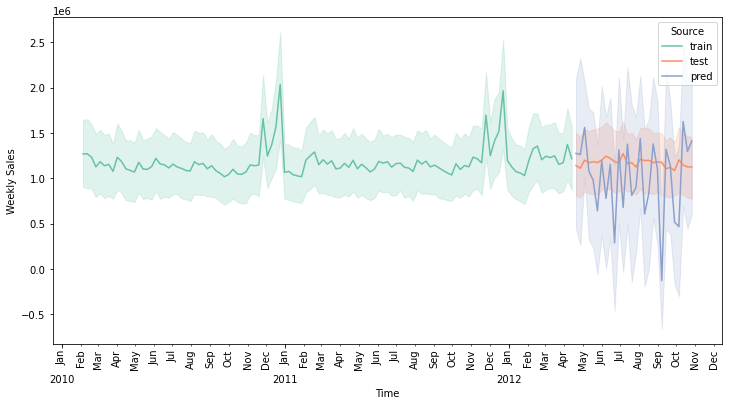

In [120]:
plot_forecast(train["y"].values, forecast["yhat"], test["y"], time=pd.concat([train["ds"], test["ds"]]).values)

In [121]:
forecast["yhat"].apply(lambda x: x<0).sum()

140

In [155]:
y_test = test[test["Region"] == 1]["y"]

In [159]:
y_test = test[test["Region"] == 1]["y"]
y_pred = forecast["yhat"]

print_evaluate_model(y_test, y_pred)

Mean Absolute Error: 1250128.9172542936
Mean Squared Error: 2332430200132.075
Root Mean Squared Error: 1527229.5833083102
Mean Percentage Error: 33.69731461123225
Mean Absolute Percentage Error: 79.95603768596673


## Misc

In [100]:
train, test = train_test_split_timeseries(region, split=0.3, group="Region")

143 101 42
143 101 42
143 101 42
143 101 42
143 101 42
143 101 42
143 101 42
143 101 42
143 101 42
143 101 42
143 101 42
143 101 42


In [101]:
train

,Region,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,False,A,151315
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,True,A,151315
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,False,A,151315
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,False,A,151315
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,False,A,151315
...,...,...,...,...,...,...,...,...,...,...
1669,12,2011-12-09,1189646.45,42.17,3.644,129.855533,12.890,False,B,112238
1670,12,2011-12-16,1293404.18,43.29,3.600,129.898065,12.890,False,B,112238
1671,12,2011-12-23,1617612.03,45.40,3.541,129.984548,12.890,False,B,112238
1672,12,2011-12-30,1111638.07,44.64,3.428,130.071032,12.890,True,B,112238
